In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from collections import Counter 
from tqdm import tqdm
from random import seed, randint, choice

from swarm_sim import *

%matplotlib inline 

In [3]:
PATH = '..\data\Traces_Nanosatellites\\track_'
satellites = {}

with tqdm(total=100, desc='Extracting data') as pbar:
    for i in range(0,100):
        df = pd.read_csv(PATH+str(i)+'.csv', sep=',', header=0)
        df['coords'] = ['x','y','z']
        satellites[i] = df.set_index('coords', drop=True)
        pbar.update(1)
    
DURATION = satellites[0].columns.tolist()

satellites[0].head()

Extracting data: 100%|██████████| 100/100 [02:11<00:00,  1.31s/it]


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
coords,,,,,,,,,,,,,,,,,,,,,
x,-4.850747e+05,-4.937755e+05,-5.024536e+05,-5.111086e+05,-5.197401e+05,-5.283476e+05,-5.369309e+05,-5.454894e+05,-5.540229e+05,-5.625310e+05,...,1.490967e+06,1.494274e+06,1.497573e+06,1.500865e+06,1.504149e+06,1.507425e+06,1.510693e+06,1.513954e+06,1.517206e+06,1.520451e+06
y,-7.066530e+05,-7.201117e+05,-7.335372e+05,-7.469290e+05,-7.602864e+05,-7.736088e+05,-7.868957e+05,-8.001464e+05,-8.133603e+05,-8.265368e+05,...,2.218138e+06,2.223313e+06,2.228477e+06,2.233629e+06,2.238769e+06,2.243898e+06,2.249015e+06,2.254120e+06,2.259214e+06,2.264296e+06
z,-2.026363e+06,-2.019625e+06,-2.012795e+06,-2.005871e+06,-1.998855e+06,-1.991747e+06,-1.984548e+06,-1.977257e+06,-1.969876e+06,-1.962403e+06,...,3.692429e+06,3.686602e+06,3.680756e+06,3.674890e+06,3.669006e+06,3.663103e+06,3.657180e+06,3.651239e+06,3.645278e+06,3.639299e+06


## Temporal evolution
Analysed metrics:
- Network size (NS)
- Average degree (AD): number of direct neighbor(s) for each node, averaged
- Graph density (GD): ratio of observed edges over maximum possible number of edges
- Average clustering coefficient (ACC): ratio of observed edges in the neighborhood over maximum possible number of edges, averaged
- Diameter (Dia): maximum shortest path length between all pairs of nodes
TODO: Betweeness centrality (BC): number of shortest paths a node is involved in

Implemented algorithms for comparison:
- Random Node Sampling (RNS)
- Multi-Dimensional Random Walk (MDRW)
- Forest Fire (FF)

In [4]:
CONNECTION_RANGE = 30000
CHUNKS = 1800     # Number of timestamps to analyse
NB_NODES = 100

swarm_topo = {}

with tqdm(total=CHUNKS, desc='Converting to Swarm') as pbar:
    for t in range(CHUNKS):
        swarm_topo[t] = Swarm(
            connection_range=CONNECTION_RANGE, 
            nodes=[Node(id, node[str(t)].x, node[str(t)].y, node[str(t)].z) for id,node in satellites.items()]
        )
        pbar.update(1)

print(swarm_topo[0])

with tqdm(total=len(swarm_topo.keys()), desc='Neighbor matrix') as pbar:
    for t in swarm_topo.keys():
        neighbor_matrix = swarm_topo[t].neighbor_matrix()
        pbar.update(1)

Converting to Swarm: 100%|██████████| 1800/1800 [00:17<00:00, 105.28it/s]


Swarm of 100 node(s), connection range: 30000


Neighbor matrix: 100%|██████████| 1800/1800 [00:17<00:00, 103.17it/s]


### Random Node Sampling (RNS)

In [59]:
clist = range(10) # List of group IDs
sf = 50 # Number of repetitions

groups = {} # Dict(timestamp:comm_data)
with tqdm(total=len(swarm_topo.keys()), desc='Random Node Sampling') as pbar:
    for t, swarm in swarm_topo.items():
        comm_data = {} # Dict(comm_id:list(count))
        for i in clist:
            comm_data[i] = []

        for i in range(sf*t, sf*(t+1)):
            swarm.RNS(clist, i)
            communities = [n.group for n in swarm.nodes]
            distrib = Counter(communities)
            for k in comm_data.keys():
                comm_data[k].append(distrib[k])
        groups[t] = comm_data
        pbar.update(1)

Random Node Sampling: 100%|██████████| 1800/1800 [01:40<00:00, 17.90it/s]


In [60]:
# Separate groups into swarms
group_swarms_rns = {} # Dict(timestamp:swarms)

for t,swarm in swarm_topo.items():
    swarms = [] #List(Swarm)
    for j in clist:
        sw = Swarm(connection_range=30000,
                        nodes=[node for node in swarm.nodes if node.group==j])
        neighbor_matrix = sw.neighbor_matrix()
        swarms.append(sw)
    group_swarms_rns[t] = swarms
    
for sw in group_swarms_rns[0]:
    print(sw)
    if sw.nodes:
        print('Group ID:', sw.nodes[0].group)

Swarm of 11 node(s), connection range: 30000
Group ID: 0
Swarm of 11 node(s), connection range: 30000
Group ID: 1
Swarm of 9 node(s), connection range: 30000
Group ID: 2
Swarm of 5 node(s), connection range: 30000
Group ID: 3
Swarm of 8 node(s), connection range: 30000
Group ID: 4
Swarm of 8 node(s), connection range: 30000
Group ID: 5
Swarm of 15 node(s), connection range: 30000
Group ID: 6
Swarm of 9 node(s), connection range: 30000
Group ID: 7
Swarm of 10 node(s), connection range: 30000
Group ID: 8
Swarm of 14 node(s), connection range: 30000
Group ID: 9


In [8]:
# Reference temporal evolution: Average Degree, Graph Density, Average Clustering Coefficient
ref_ad, ref_gd, ref_acc = [], [], []

for t,swarm in swarm_topo.items():
    ref_ad.append(np.mean(swarm.degree()))
    ref_gd.append(swarm.graph_density())
    ref_acc.append(np.mean(swarm.cluster_coef()))

# Group temporal evolution: Average Degree, Graph Density, Average Clustering Coefficient
group_ad, group_gd, group_acc = [], [], []

for t,swarms in group_swarms_rns.items():
    group_ad.append(np.mean([np.mean(sw.degree()) for sw in swarms]))
    group_gd.append(np.mean([sw.graph_density() for sw in swarms]))
    group_acc.append(np.mean([np.mean(sw.cluster_coef()) for sw in swarms]))  
    
len(ref_ad) == len(group_ad)

True

In [9]:
avg_group_ad = np.mean(group_ad)
avg_group_acc = np.mean(group_acc)    
avg_group_gd = np.mean(group_gd)

avg_ref_ad = np.mean(ref_ad)
avg_ref_acc = np.mean(ref_acc)
avg_ref_gd = np.mean(ref_gd)

std_ad = np.sqrt(np.mean((group_ad - avg_ref_ad)**2))
std_acc = np.sqrt(np.mean((group_acc - avg_ref_acc)**2))
std_gd = np.sqrt(np.mean((group_gd - avg_ref_gd)**2))

x = 2
print('Reference values (whole swarm)')
print('\tAverage degree:', round(avg_ref_ad, x))
print('\tAverage clustering coefficient:', round(avg_ref_acc, x))
print('\tGraph Density:', round(avg_ref_gd, x))

print('\nGroup values')
print('\tAverage degree:', round(avg_group_ad, x))
print('\tAverage clustering coefficient:', round(avg_group_acc, x))
print('\tGraph Density:', round(avg_group_gd, x))

print('\nStandard deviations')
print('\tAD:', round(std_ad, x))
print('\tACC:', round(std_acc, x))
print('\tGD:', round(std_gd, x))

print('\nVariation coefficients')
print('\tAD:', round(std_ad/avg_group_ad, x+2))
print('\tACC:', round(std_acc/avg_group_acc, x+2))
print('\tGD:', round(std_gd/avg_group_gd, x+2))

Reference values (whole swarm)
	Average degree: 8.17
	Average clustering coefficient: 0.5
	Graph Density: 0.08

Group values
	Average degree: 8.17
	Average clustering coefficient: 0.5
	Graph Density: 0.08

Standard deviations
	AD: 1.8
	ACC: 0.05
	GD: 0.02

Variation coefficients
	AD: 0.2201
	ACC: 0.11
	GD: 0.2957


In [3]:
# Jain's fairness index (see https://en.wikipedia.org/wiki/Fairness_measure)
cv_ad = 0.2201
cv_acc = 0.11
cv_gd = 0.2957

def J(cv):
    return 1.0/(1 + pow(cv,2))

print('J(AD) =', J(cv_ad))
print('J(ACC) =', J(cv_acc))
print('J(GD) =', J(cv_gd))

J(AD) = 0.9537943757244604
J(ACC) = 0.9880446596186148
J(GD) = 0.9195922428679161


Text(0.5, 0.98, 'Temporal evolution of metrics as a swarm and as groups (RNS)')

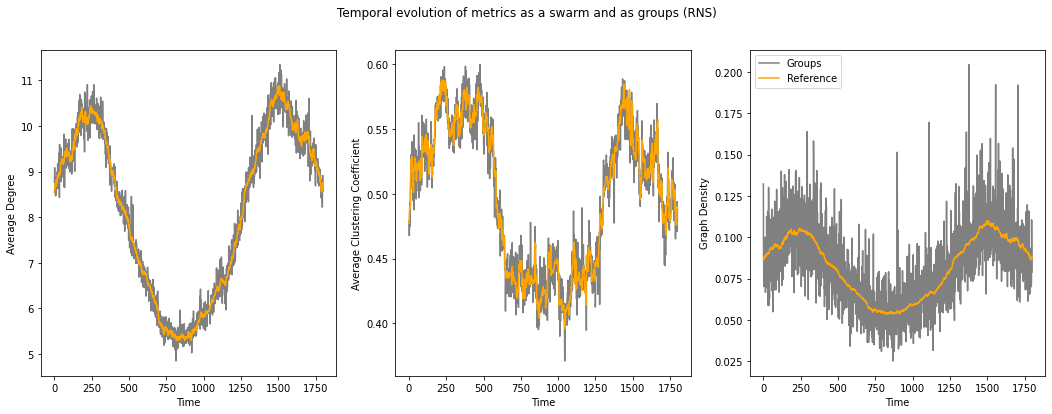

In [10]:
# Plot the group/reference evolution
fig,axes = plt.subplots(ncols=3, figsize=(18,6))
idx = np.arange(len(ref_ad))

ax = axes[0]
ax.plot(idx, group_ad, c='gray')
ax.plot(idx, ref_ad, c='orange')
ax.set_xlabel('Time')
ax.set_ylabel('Average Degree')

ax = axes[1]
ax.plot(idx, group_acc, c='gray')
ax.plot(idx, ref_acc, c='orange')
ax.set_xlabel('Time')
ax.set_ylabel('Average Clustering Coefficient')

ax = axes[2]
ax.plot(idx, group_gd, c='gray')
ax.plot(idx, ref_gd, c='orange')
ax.set_xlabel('Time')
ax.set_ylabel('Graph Density')
ax.legend(['Groups','Reference'])

plt.suptitle('Temporal evolution of metrics as a swarm and as groups (RNS)')

In [61]:
t = 0
ref_ml = swarm_topo[t].diameter(swarm)[2]-1
group_ml = [swarm.diameter(sw)[2]-1 for sw in group_swarms_rns[t]]
 
avg_ml = np.mean(group_ml)   
std_ml = np.std(group_ml)

x = 2
print('Reference diameter:', ref_ml, 'hops')
print('Average group diameter:', round(avg_ml, x), 'hops')
print('Standard deviation wrt self:', round(std_ml, x))
print('Variation coefficient:', round(std_ml/avg_ml, x+2))

Reference diameter: 10 hops
Average group diameter: 6.8 hops
Standard deviation wrt self: 1.94
Variation coefficient: 0.2852


In [4]:
# Jain's fairness index (see https://en.wikipedia.org/wiki/Fairness_measure)
cv_ml = 0.2852

def J(cv):
    return 1.0/(1 + pow(cv,2))

print('J(Dia) =', J(cv_ml))

J(Dia) = 0.9247793365529464


In [13]:
comm_data = groups[1] # Dict(comm_id:list(count))
group_distrib_list = [e for distribs in comm_data.values() for e in distribs]

print('Average network size:', np.mean(group_distrib_list))
print('Median network size:', np.median(group_distrib_list))
print('Standard deviation:', np.std(group_distrib_list))

distrib = Counter(group_distrib_list)

labels = sorted(distrib.keys())
x_pos = np.arange(min(labels), max(labels)+1)
data = []
for k in x_pos:
       x = 0
       if k in labels:
              x = distrib[k]
       data.append(x)

Average network size: 10.0
Median network size: 10.0
Standard deviation: 2.9400680264238783


In [5]:
# Jain's fairness index (see https://en.wikipedia.org/wiki/Fairness_measure)
cv_ns = 2.94/10.0

def J(cv):
    return 1.0/(1 + pow(cv,2))

print('J(NS) =', J(cv_ns))

J(NS) = 0.9204407806810526


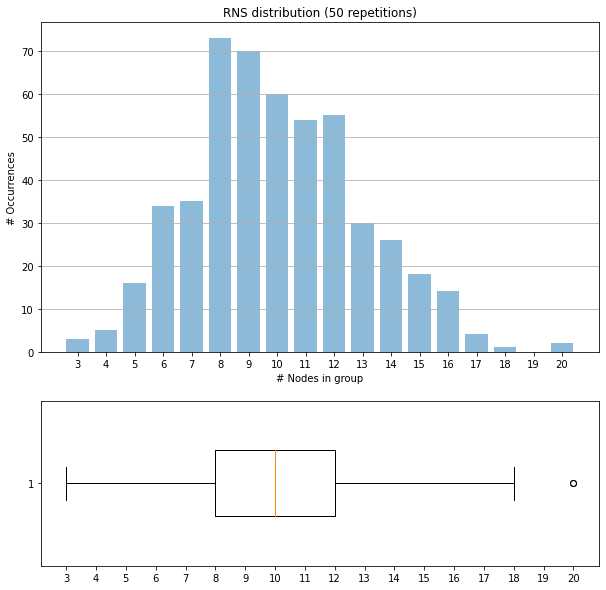

In [14]:
# Build the plot
fig, axes = plt.subplots(nrows=2, figsize=(10,10), gridspec_kw={'height_ratios': [2, 1]})
ax = axes[0] # Plot bar distribution
ax.bar(x_pos, data,
       align='center',
       alpha=0.5)
ax.set_xlabel('# Nodes in group')
ax.set_ylabel('# Occurrences')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_pos)
ax.set_title('RNS distribution (50 repetitions)')
ax.yaxis.grid(True)

ax = axes[1] # Boxplot distribution
ax.boxplot(sorted(distrib.elements()),
           widths=0.4,
           vert=False)
ax.set_xticks(x_pos)

### Multi-Dimensional Random Walk (MDRW)

In [15]:
group_ids = range(10) # List of group IDs
sf = 50 # Number of repetitions

groups_mdrw = {} # Dict(timestamp:comm_data)
with tqdm(total=len(swarm_topo.keys()), desc='MDRW') as pbar:
    for t, swarm in swarm_topo.items():
        swarm.reset_groups()
        comm_data = {} # Dict(comm_id:list(count))
        for i in group_ids:
            comm_data[i] = []
        comm_data[-1] = [] # Possible unassigned nodes

        for i in range(sf*t, sf*(t+1)):
            swarm.MDRW(s=i)
            communities = [n.group for n in swarm.nodes]
            distrib = Counter(communities)
            for k in comm_data.keys():
                comm_data[k].append(distrib[k])
        groups_mdrw[t] = comm_data
        pbar.update(1)

MDRW: 100%|██████████| 1800/1800 [00:06<00:00, 278.63it/s]


In [16]:
# Separate groups into swarms
group_swarms_mdrw = {} # Dict(timestamp:swarms)
group_unassigned = {} # Dict(timestamp:Swarm)

for t,swarm in swarm_topo.items():
    swarms = [] #List(Swarm)
    for j in group_ids:
        sw = Swarm(connection_range=30000,
                        nodes=[node for node in swarm.nodes if node.group==j])
        neighbor_matrix = sw.neighbor_matrix()
        swarms.append(sw)
    group_swarms_mdrw[t] = swarms
    group_unassigned[t] = Swarm(connection_range=30000,
                             nodes=[node for node in swarm.nodes if node.group==-1])

In [17]:
for sw in group_swarms_mdrw[0]:
    print(sw)
    if sw.nodes:
        print('Group ID:', sw.nodes[0].group)

swu = group_unassigned[0]
print('\n', swu)

Swarm of 11 node(s), connection range: 30000
Group ID: 0
Swarm of 7 node(s), connection range: 30000
Group ID: 1
Swarm of 11 node(s), connection range: 30000
Group ID: 2
Swarm of 11 node(s), connection range: 30000
Group ID: 3
Swarm of 8 node(s), connection range: 30000
Group ID: 4
Swarm of 11 node(s), connection range: 30000
Group ID: 5
Swarm of 12 node(s), connection range: 30000
Group ID: 6
Swarm of 11 node(s), connection range: 30000
Group ID: 7
Swarm of 10 node(s), connection range: 30000
Group ID: 8
Swarm of 8 node(s), connection range: 30000
Group ID: 9

 Swarm of 0 node(s), connection range: 30000


In [31]:
t = 0
ref_ml = swarm_topo[t].diameter(swarm)[2]
group_ml = [swarm.diameter(sw)[2] for sw in group_swarms_mdrw[t]]
 
avg_ml = np.mean(group_ml)   
std_ml = np.std(group_ml)

x = 2
print('Reference diameter:', ref_ml, 'hops')
print('Average group diameter:', round(avg_ml, x))
print('Standard deviation wrt self:', round(std_ml, x))
print('Variation coefficient:', round(std_ml/avg_ml, x+2))

Reference diameter: 11 hops
Average group diameter: 8.2
Standard deviation wrt self: 1.66
Variation coefficient: 0.2026


In [6]:
print('J(Dia) =', J(0.2026))

J(Dia) = 0.9605716461765849


Text(0.5, 0, 'Shortest path length distribution')

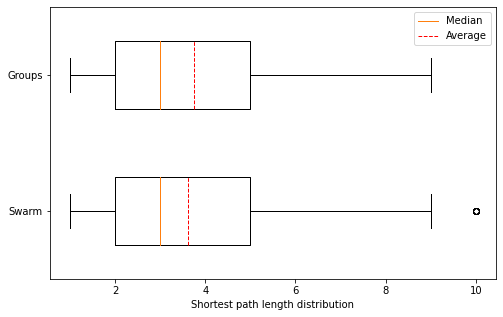

In [19]:
data_swarm = swarm.shortest_paths_lengths(swarm)

data_group = []
for sw in group_swarms_mdrw[0]:
    data_group.extend(swarm.shortest_paths_lengths(sw))


fig,ax = plt.subplots(figsize=(8,5))
bp = ax.boxplot([data_swarm, data_group], 
            vert=False, 
            widths=0.5,
            meanline=True, 
            showmeans=True, 
            meanprops={'color':'red','ls':'--'}
            )
ax.legend([bp['medians'][0], bp['means'][0]], ['Median', 'Average'])
ax.set_yticklabels(['Swarm','Groups']) #degree_range.keys()
ax.set_xlabel('Shortest path length distribution')

In [20]:
# Reference temporal evolution: Average Degree, Graph Density, Average Clustering Coefficient
ref_ad, ref_gd, ref_acc = [], [], []

for t,swarm in swarm_topo.items():
    ref_ad.append(np.mean(swarm.degree()))
    ref_gd.append(swarm.graph_density())
    ref_acc.append(np.mean(swarm.cluster_coef()))
    
# Group temporal evolution: Average Degree, Graph Density, Average Clustering Coefficient
group_ad, group_gd, group_acc = [], [], []

for t,swarms in group_swarms_mdrw.items():
    group_ad.append(np.mean([np.mean(sw.degree()) for sw in swarms]))
    group_gd.append(np.mean([sw.graph_density() for sw in swarms]))
    group_acc.append(np.mean([np.mean(sw.cluster_coef()) for sw in swarms]))  
    
len(ref_ad) == len(group_ad)

True

In [21]:
avg_group_ad = np.nanmean(group_ad)
avg_group_acc = np.nanmean(group_acc)    
avg_group_gd = np.nanmean(group_gd)

avg_ref_ad = np.mean(ref_ad)
avg_ref_acc = np.mean(ref_acc)
avg_ref_gd = np.mean(ref_gd)

std_ad = np.sqrt(np.nanmean((group_ad - avg_ref_ad)**2))
std_acc = np.sqrt(np.nanmean((group_acc - avg_ref_acc)**2))
std_gd = np.sqrt(np.nanmean((group_gd - avg_ref_gd)**2))

x = 2
print('Reference values (whole swarm)')
print('\tAverage degree:', round(avg_ref_ad, x))
print('\tAverage clustering coefficient:', round(avg_ref_acc, x))
print('\tGraph Density:', round(avg_ref_gd, x))

print('\nGroup values')
print('\tAverage degree:', round(avg_group_ad, x))
print('\tAverage clustering coefficient:', round(avg_group_acc, x))
print('\tGraph Density:', round(avg_group_gd, x))

print('\nStandard deviations')
print('\tAD:', round(std_ad, x))
print('\tACC:', round(std_acc, x))
print('\tGD:', round(std_gd, x))

print('\nVariation coefficients')
print('\tAD:', round(std_ad/avg_group_ad, x+2))
print('\tACC:', round(std_acc/avg_group_acc, x+2))
print('\tGD:', round(std_gd/avg_group_gd, x+2))

Reference values (whole swarm)
	Average degree: 8.17
	Average clustering coefficient: 0.5
	Graph Density: 0.08

Group values
	Average degree: 8.17
	Average clustering coefficient: 0.5
	Graph Density: 0.08

Standard deviations
	AD: 1.8
	ACC: 0.05
	GD: 0.02

Variation coefficients
	AD: 0.2201
	ACC: 0.1099
	GD: 0.2709


In [7]:
print('J(AD) =', J(0.2201))
print('J(ACC) =', J(0.1099))
print('J(GD) =', J(0.2709))

J(AD) = 0.9537943757244604
J(ACC) = 0.9880661274322124
J(GD) = 0.9316306020194156


Text(0.5, 0.98, 'Temporal evolution of metrics as a swarm and as groups (MDRW)')

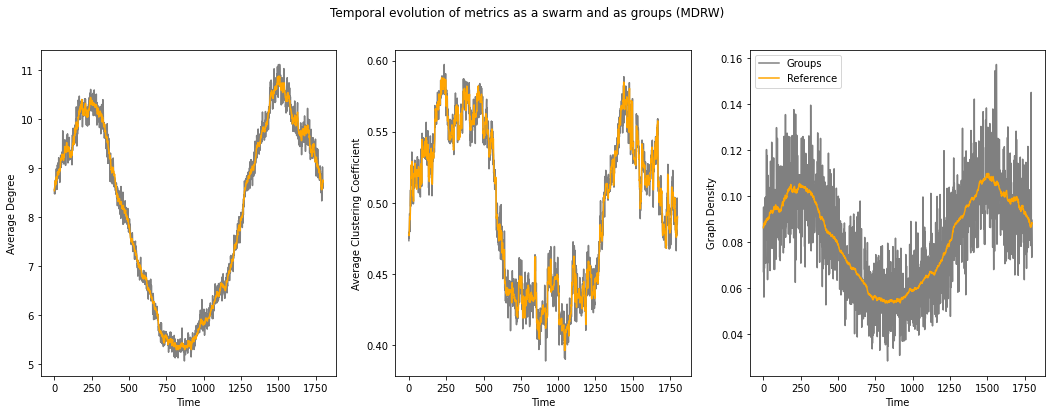

In [22]:
# Plot the group/reference evolution
fig,axes = plt.subplots(ncols=3, figsize=(18,6))
idx = np.arange(len(ref_ad))

ax = axes[0]
ax.plot(idx, group_ad, c='gray')
ax.plot(idx, ref_ad, c='orange')
ax.set_xlabel('Time')
ax.set_ylabel('Average Degree')

ax = axes[1]
ax.plot(idx, group_acc, c='gray')
ax.plot(idx, ref_acc, c='orange')
ax.set_xlabel('Time')
ax.set_ylabel('Average Clustering Coefficient')

ax = axes[2]
ax.plot(idx, group_gd, c='gray')
ax.plot(idx, ref_gd, c='orange')
ax.set_xlabel('Time')
ax.set_ylabel('Graph Density')
ax.legend(['Groups','Reference'])

plt.suptitle('Temporal evolution of metrics as a swarm and as groups (MDRW)')

In [23]:
comm_data = groups_mdrw[1] # Dict(comm_id:list(count))
group_distrib_list = [e for k,distribs in comm_data.items() for e in distribs if k!=-1]

print('Average network size:', np.mean(group_distrib_list))
print('Median network size:', np.median(group_distrib_list))
print('Standard deviation:', np.std(group_distrib_list))
print(sorted(distrib.keys()))

distrib = Counter(group_distrib_list)

labels = sorted(distrib.keys())
x_pos = np.arange(min(labels), max(labels)+1)
data = []
for k in x_pos:
       x = 0
       if k in labels:
              x = distrib[k]
       data.append(x)

Average network size: 10.0
Median network size: 10.0
Standard deviation: 1.8536450577173613
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [8]:
print('J(NS) =', J(1.8536450577173613/10.0))

J(NS) = 0.9667813913917785


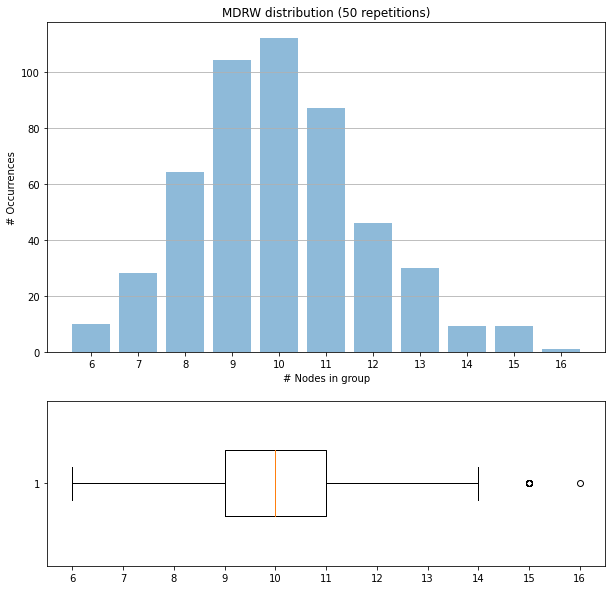

In [24]:
# Build the plot
fig, axes = plt.subplots(nrows=2, figsize=(10,10), gridspec_kw={'height_ratios': [2, 1]})
ax = axes[0] # Plot bar distribution
ax.bar(x_pos, data,
       align='center',
       alpha=0.5)
ax.set_xlabel('# Nodes in group')
ax.set_ylabel('# Occurrences')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_pos)
ax.set_title('MDRW distribution (50 repetitions)')
ax.yaxis.grid(True)

ax = axes[1] # Boxplot distribution
ax.boxplot(sorted(distrib.elements()),
           widths=0.4,
           vert=False)
ax.set_xticks(x_pos)

### Forest Fire Model

In [33]:
group_ids = range(10) # List of group IDs
sf = 50 # Number of repetitions

groups_ff = {} # Dict(timestamp:comm_data)
with tqdm(total=len(swarm_topo.keys()), desc='Forest Fire') as pbar:
    for t, swarm in swarm_topo.items():
        swarm.reset_groups()
        comm_data = {} # Dict(comm_id:list(count))
        for i in group_ids:
            comm_data[i] = []
        comm_data[-1] = [] # Possible unassigned nodes

        for i in range(sf*t, sf*(t+1)):
            swarm.ForestFire(n=10, p=0.7, s=i)
            communities = [n.group for n in swarm.nodes]
            distrib = Counter(communities)
            for k in comm_data.keys():
                comm_data[k].append(distrib[k])
        groups_ff[t] = comm_data
        pbar.update(1)

Forest Fire: 100%|██████████| 1800/1800 [00:05<00:00, 308.30it/s]


In [34]:
# Separate groups into swarms
group_swarms_ff = {} # Dict(timestamp:swarms)
group_unassigned = {} # Dict(timestamp:Swarm)

for t,swarm in swarm_topo.items():
    swarms = [] #List(Swarm)
    for j in group_ids:
        sw = Swarm(connection_range=30000,
                        nodes=[node for node in swarm.nodes if node.group==j])
        neighbor_matrix = sw.neighbor_matrix()
        swarms.append(sw)
    group_swarms_ff[t] = swarms
    group_unassigned[t] = Swarm(connection_range=30000,
                             nodes=[node for node in swarm.nodes if node.group==-1])

In [35]:
for sw in group_swarms_ff[0]:
    print(sw)
    if sw.nodes:
        print(sw.nodes[0])

swu = group_unassigned[0]
print('\n', swu)
if swu.nodes:
    print(swu.nodes[0])

Swarm of 11 node(s), connection range: 30000
Node ID 0 (-485074.678663292,-706653.009498108,-2026363.46336954) has 4 neighbor(s)	Group: 0
Swarm of 7 node(s), connection range: 30000
Node ID 6 (-423822.113747743,-693079.060304235,-2033733.90184913) has 16 neighbor(s)	Group: 1
Swarm of 10 node(s), connection range: 30000
Node ID 1 (-416730.457242747,-711449.610260252,-2013985.12080213) has 6 neighbor(s)	Group: 2
Swarm of 11 node(s), connection range: 30000
Node ID 4 (-457421.163517887,-666330.96572567,-1985844.42258975) has 1 neighbor(s)	Group: 3
Swarm of 8 node(s), connection range: 30000
Node ID 11 (-458066.47668205,-734366.762447103,-2024861.7874912) has 16 neighbor(s)	Group: 4
Swarm of 11 node(s), connection range: 30000
Node ID 8 (-417276.140034617,-675866.187442782,-2007666.08226784) has 7 neighbor(s)	Group: 5
Swarm of 12 node(s), connection range: 30000
Node ID 9 (-450570.052895477,-709565.244861892,-2007467.58188223) has 18 neighbor(s)	Group: 6
Swarm of 11 node(s), connection ran

In [36]:
# Reference temporal evolution: Average Degree, Graph Density, Average Clustering Coefficient
ref_ad, ref_gd, ref_acc = [], [], []

for t,swarm in swarm_topo.items():
    ref_ad.append(np.mean(swarm.degree()))
    ref_gd.append(swarm.graph_density())
    ref_acc.append(np.mean(swarm.cluster_coef()))
    
# Group temporal evolution: Average Degree, Graph Density, Average Clustering Coefficient
group_ad, group_gd, group_acc = [], [], []

for t,swarms in group_swarms_ff.items():
    group_ad.append(np.mean([np.mean(sw.degree()) for sw in swarms]))
    group_gd.append(np.mean([sw.graph_density() for sw in swarms]))
    group_acc.append(np.mean([np.mean(sw.cluster_coef()) for sw in swarms]))  
    
len(ref_ad) == len(group_ad)

True

In [37]:
avg_group_ad = np.nanmean(group_ad)
avg_group_acc = np.nanmean(group_acc)    
avg_group_gd = np.nanmean(group_gd)

avg_ref_ad = np.mean(ref_ad)
avg_ref_acc = np.mean(ref_acc)
avg_ref_gd = np.mean(ref_gd)

std_ad = np.sqrt(np.nanmean((group_ad - avg_ref_ad)**2))
std_acc = np.sqrt(np.nanmean((group_acc - avg_ref_acc)**2))
std_gd = np.sqrt(np.nanmean((group_gd - avg_ref_gd)**2))

x = 2
print('Reference values (whole swarm)')
print('\tAverage degree:', round(avg_ref_ad, x))
print('\tAverage clustering coefficient:', round(avg_ref_acc, x))
print('\tGraph Density:', round(avg_ref_gd, x))

print('\nGroup values')
print('\tAverage degree:', round(avg_group_ad, x))
print('\tAverage clustering coefficient:', round(avg_group_acc, x))
print('\tGraph Density:', round(avg_group_gd, x))

print('\nStandard deviations')
print('\tAD:', round(std_ad, x))
print('\tACC:', round(std_acc, x))
print('\tGD:', round(std_gd, x))

print('\nVariation coefficients')
print('\tAD:', round(std_ad/avg_group_ad, x+2))
print('\tACC:', round(std_acc/avg_group_acc, x+2))
print('\tGD:', round(std_gd/avg_group_gd, x+2))

Reference values (whole swarm)
	Average degree: 8.17
	Average clustering coefficient: 0.5
	Graph Density: 0.08

Group values
	Average degree: 8.17
	Average clustering coefficient: 0.5
	Graph Density: 0.08

Standard deviations
	AD: 1.8
	ACC: 0.05
	GD: 0.02

Variation coefficients
	AD: 0.22
	ACC: 0.1101
	GD: 0.2717


In [9]:
print('J(AD) =', J(0.22))
print('J(ACC) =', J(0.1101))
print('J(GD) =', J(0.2717))

J(AD) = 0.9538344143456696
J(ACC) = 0.9880231732140674
J(GD) = 0.9312540008417978


Text(0.5, 0.98, 'Temporal evolution of metrics as a swarm and as groups (ForestFire)')

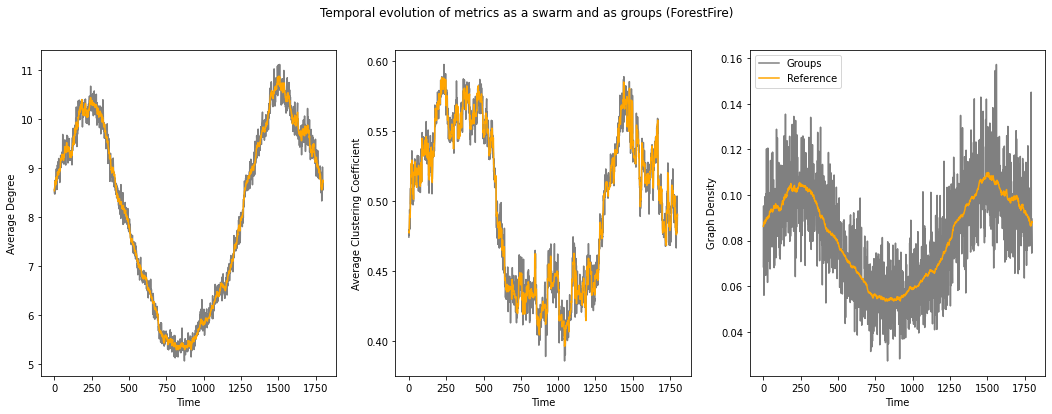

In [30]:
# Plot the group/reference evolution
fig,axes = plt.subplots(ncols=3, figsize=(18,6))
idx = np.arange(len(ref_ad))

ax = axes[0]
ax.plot(idx, group_ad, c='gray')
ax.plot(idx, ref_ad, c='orange')
ax.set_xlabel('Time')
ax.set_ylabel('Average Degree')

ax = axes[1]
ax.plot(idx, group_acc, c='gray')
ax.plot(idx, ref_acc, c='orange')
ax.set_xlabel('Time')
ax.set_ylabel('Average Clustering Coefficient')

ax = axes[2]
ax.plot(idx, group_gd, c='gray')
ax.plot(idx, ref_gd, c='orange')
ax.set_xlabel('Time')
ax.set_ylabel('Graph Density')
ax.legend(['Groups','Reference'])

plt.suptitle('Temporal evolution of metrics as a swarm and as groups (ForestFire)')

In [57]:
t = 0
ref_ml = swarm_topo[t].diameter(swarm)[2]-1
group_ml = [swarm.diameter(sw)[2]-1 for sw in group_swarms_ff[t]]
 
avg_ml = np.mean(group_ml)   
std_ml = np.std(group_ml)

x = 2
print('Reference diameter:', ref_ml, 'hops')
print('Average group diameter:', round(avg_ml, x))
print('Standard deviation wrt self:', round(std_ml, x))
print('Variation coefficient:', round(std_ml/avg_ml, x+2))

Reference diameter: 10 hops
Average group diameter: 7.2
Standard deviation wrt self: 1.66
Variation coefficient: 0.2307


In [10]:
print('J(Dia) =', J(0.2307))

J(Dia) = 0.949467001981699


In [40]:
comm_data = groups_ff[1] # Dict(comm_id:list(count))
group_distrib_list = [e for k,distribs in comm_data.items() for e in distribs if k!=-1]

print('Number of nodes per group\n')
print('Average:', np.mean(group_distrib_list))
print('Median:', np.median(group_distrib_list))
print('Standard deviation:', np.std(group_distrib_list))
print(sorted(distrib.keys()))

distrib = Counter(group_distrib_list)

labels = sorted(distrib.keys())
x_pos = np.arange(min(labels), max(labels)+1)
data = []
for k in x_pos:
       x = 0
       if k in labels:
              x = distrib[k]
       data.append(x)

Number of nodes per group

Average: 10.0
Median: 10.0
Standard deviation: 3.0152943471575044
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [11]:
print('J(NS) =', J(3.0152943471575044/10.0))

J(NS) = 0.9166575000916657


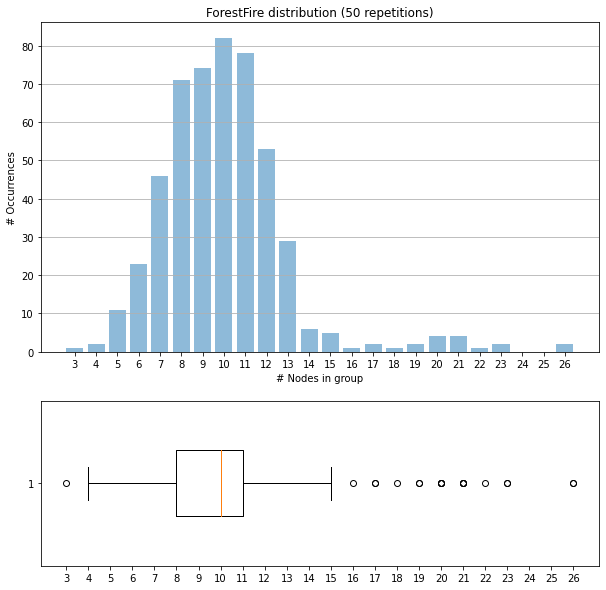

In [41]:
# Build the plot
fig, axes = plt.subplots(nrows=2, figsize=(10,10), gridspec_kw={'height_ratios': [2, 1]})
ax = axes[0] # Plot bar distribution
ax.bar(x_pos, data,
       align='center',
       alpha=0.5)
ax.set_xlabel('# Nodes in group')
ax.set_ylabel('# Occurrences')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_pos)
ax.set_title('ForestFire distribution (50 repetitions)')
ax.yaxis.grid(True)

ax = axes[1] # Boxplot distribution
ax.boxplot(sorted(distrib.elements()),
           widths=0.4,
           vert=False)
ax.set_xticks(x_pos)

### Shortest paths distribution comparison

In [44]:
clist = range(10) # List of group IDs
sf = 50 # Number of repetitions
t = 0
groups = {} # Dict(algorithm:comm_data)
group_swarms = {} # Dict(algorithm:swarms)
swarm = swarm_topo[t]

#************* RNS ***************
swarm.reset_groups()
comm_data = {} # Dict(comm_id:list(count))
for i in clist:
    comm_data[i] = []

for i in range(sf*t, sf*(t+1)):
    swarm.RNS(clist, i)
    communities = [n.group for n in swarm.nodes]
    distrib = Counter(communities)
    for k in comm_data.keys():
        comm_data[k].append(distrib[k])
groups['RNS'] = comm_data

swarms = [] #List(Swarm)
for j in clist:
    sw = Swarm(connection_range=30000,
                    nodes=[node for node in swarm.nodes if node.group==j])
    neighbor_matrix = sw.neighbor_matrix()
    swarms.append(sw)
group_swarms['RNS'] = swarms


#************** MDRW *****************
swarm.reset_groups()
comm_data = {} # Dict(comm_id:list(count))
for i in group_ids:
    comm_data[i] = []

for i in range(sf*t, sf*(t+1)):
    swarm.MDRW(s=i)
    communities = [n.group for n in swarm.nodes]
    distrib = Counter(communities)
    for k in comm_data.keys():
        comm_data[k].append(distrib[k])
groups['MDRW'] = comm_data

swarms = [] #List(Swarm)
for j in clist:
    sw = Swarm(connection_range=30000,
                    nodes=[node for node in swarm.nodes if node.group==j])
    neighbor_matrix = sw.neighbor_matrix()
    swarms.append(sw)
group_swarms['MDRW'] = swarms


#************* FF ********************
swarm.reset_groups()
comm_data = {} # Dict(comm_id:list(count))
for i in group_ids:
    comm_data[i] = []

for i in range(sf*t, sf*(t+1)):
    swarm.ForestFire(n=10, p=0.7, s=i)
    communities = [n.group for n in swarm.nodes]
    distrib = Counter(communities)
    for k in comm_data.keys():
        comm_data[k].append(distrib[k])
groups['FF'] = comm_data

swarms = [] #List(Swarm)
for j in clist:
    sw = Swarm(connection_range=30000,
                    nodes=[node for node in swarm.nodes if node.group==j])
    neighbor_matrix = sw.neighbor_matrix()
    swarms.append(sw)
group_swarms['FF'] = swarms

Text(0.5, 0, 'Shortest path length distribution')

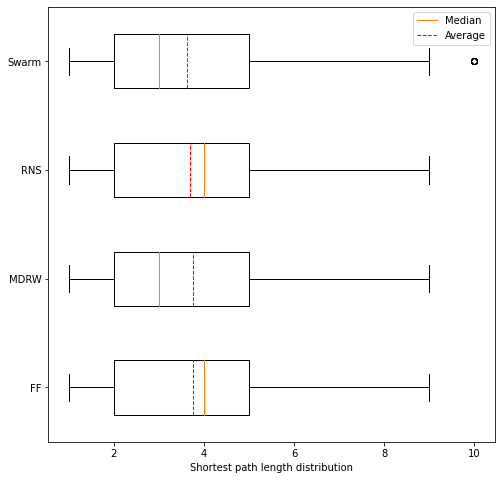

In [56]:
data_swarm = swarm.shortest_paths_lengths(swarm)

data_rns = []
for sw in group_swarms['RNS']:
    data_rns.extend(swarm.shortest_paths_lengths(sw))

data_mdrw = []
for sw in group_swarms['MDRW']:
    data_mdrw.extend(swarm.shortest_paths_lengths(sw))

data_ff = []
for sw in group_swarms['FF']:
    data_ff.extend(swarm.shortest_paths_lengths(sw))


fig,ax = plt.subplots(figsize=(8,8))
bp = ax.boxplot([data_ff, data_mdrw, data_rns, data_swarm], 
            vert=False, 
            widths=0.5,
            meanline=True, 
            showmeans=True, 
            meanprops={'color':'red','ls':'--'}
            )
ax.legend([bp['medians'][0], bp['means'][0]], ['Median', 'Average'])
ax.set_yticklabels(['FF','MDRW','RNS','Swarm']) 
ax.set_xlabel('Shortest path length distribution')